In [26]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras import applications
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras import initializers
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import imgaug.augmenters as iaa
import cv2
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [14]:
inp_image_paths,inp_target_labels,test_image_paths,test_target_labels = np.load('path_data.npy',allow_pickle=True)

In [15]:

le = preprocessing.LabelEncoder()
inp_target_labels = le.fit_transform(inp_target_labels)
test_target_labels = le.transform(test_target_labels)

## Custom Dataset and Dataloader

In [36]:
class Dataset:
    
    def __init__(self, image_paths, target_labels,trigger = 'train'):
        
        self.image_paths = image_paths
        self.trigger = trigger
        # print(self.ids)
        # the paths of images
        self.target = target_labels
            

        # print(self.class_values)
    
    def __getitem__(self,i):
        
                # read data for images and mask and resize
        image = cv2.imread(self.image_paths[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = image/255.0
        
        if self.trigger == "train":
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)

            elif a<0.4:
                image = aug3.augment_image(image)

            elif a<0.6:
                image = aug4.augment_image(image)

            elif a<0.8:
                image = aug5.augment_image(image)

            else:
                image = aug6.augment_image(image)


        return image, self.target[i]
    
    
    def __len__(self):
        return len(self.image_paths)


In [37]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [38]:
train_dataset = Dataset(inp_image_paths, inp_target_labels,trigger='train')
BATCH_SIZE = 32
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [39]:
test_dataset = Dataset(test_image_paths, test_target_labels,trigger='test')
BATCH_SIZE = 32
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Utility function for printing confusion matrix


In [40]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 12,12 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9,10,11,12]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Simple Model

In [20]:
input_layer=layers.Input(shape=(512,512,3),name='input_layer')
Conv1=layers.Conv2D(filters=16,kernel_size=(1,1),activation='relu',padding='same',kernel_initializer=initializers.he_normal(seed=18),name='Conv1')(input_layer)
Pool1=MaxPool2D(pool_size=(2,2),strides=(2,2),name='Pool1')(Conv1)
Pool2=MaxPool2D(pool_size=(2,2),strides=(2,2),name='Pool2')(Pool1)
flatten=Flatten(name='Flatten')(Pool2)
Dense1=Dense(16,activation='relu',kernel_initializer=initializers.he_normal(seed=98),name='Dense1')(flatten)
Dropout1=Dropout(0.2)(Dense1)
Dense2=Dense(16,activation='relu',name='Dense2')(Dropout1)
Dense3=Dense(16,activation='relu',name='Dense3')(Dense2)
Dense4=Dense(12,activation='softmax',kernel_initializer=initializers.he_normal(seed=54),name='Dense4')(Dense3)
simple_model=Model(inputs=input_layer,outputs=Dense4)

In [21]:
simple_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512, 512, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 512, 512, 16)      64        
                                                                 
 Pool1 (MaxPooling2D)        (None, 256, 256, 16)      0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 128, 128, 16)      0         
                                                                 
 Flatten (Flatten)           (None, 262144)            0         
                                                                 
 Dense1 (Dense)              (None, 16)                4194320   
                                                                 
 dropout_5 (Dropout)         (None, 16)                0   

In [22]:
simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [24]:
history = simple_model.fit(train_dataloader,epochs=4)

2021-12-19 06:15:32.245006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-19 06:15:32.434756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/4
36/36 [==============================] - 94s 3s/step - loss: 4.7952 - accuracy: 0.0590
Epoch 2/4
36/36 [==============================] - 92s 3s/step - loss: 2.4865 - accuracy: 0.0590
Epoch 3/4
36/36 [==============================] - 90s 2s/step - loss: 2.4859 - accuracy: 0.0312
Epoch 4/4
36/36 [==============================] - 90s 2s/step - loss: 2.4855 - accuracy: 0.0556


In [28]:
predict_y = simple_model.predict(test_dataloader)
y_pred = np.argmax(predict_y,axis = 1)

2021-12-19 06:28:36.127693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Number of misclassified points  91.31944444444444
-------------------------------------------------- Confusion matrix --------------------------------------------------


/var/folders/8w/7ycx8hfd7sl719t59ddd72qr0000gn/T/ipykernel_69414/1084658403.py:22: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


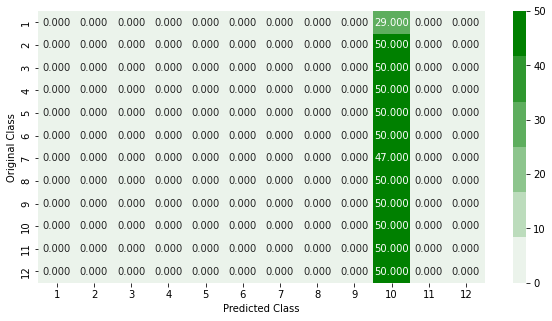

-------------------------------------------------- Precision matrix --------------------------------------------------


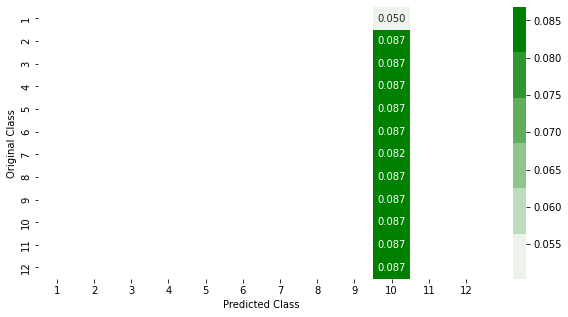

Sum of columns in precision matrix [nan nan nan nan nan nan nan nan nan  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


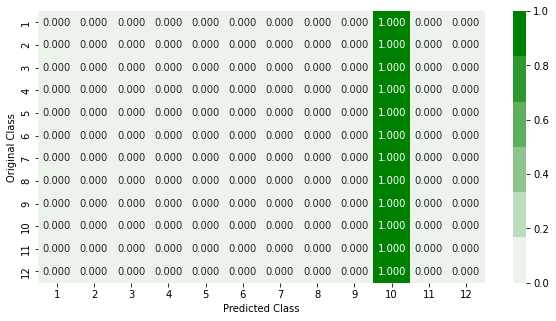

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
plot_confusion_matrix(test_target_labels[:576],y_pred)

Using Transfer Learning on a Pre-trained model

In [30]:
model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(512,512,3),
    classifier_activation='softmax'
)
for layer in model.layers:
    layer.trainable = False

In [31]:
input_layer=layers.Input(shape=model.output_shape[1:],name='input_layer')
Conv1=layers.Conv2D(filters=64,kernel_size=(1,1),activation='relu',padding='same',kernel_initializer=initializers.he_normal(seed=18),name='Conv1')(input_layer)
Pool1=MaxPool2D(pool_size=(2,2),strides=(2,2),name='Pool1')(Conv1)
flatten=Flatten(name='Flatten')(Pool1)
Dense1=Dense(128,activation='relu',kernel_initializer=initializers.he_normal(seed=98),name='Dense1')(flatten)
Dropout1=Dropout(0.2)(Dense1)
Dense2=Dense(64,activation='relu',name='Dense2')(Dropout1)
Dense3=Dense(32,activation='relu',name='Dense3')(Dense2)
Dense4=Dense(12,activation='softmax',kernel_initializer=initializers.he_normal(seed=54),name='Dense4')(Dense3)
top_model=Model(inputs=input_layer,outputs=Dense4)

In [32]:
final_model=Model(inputs=model.input,outputs=top_model(model.output))


In [33]:
final_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history1 = final_model.fit(train_dataloader,epochs=4)

Epoch 1/4


2021-12-19 06:30:58.524534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 102s 3s/step - loss: 2.6745 - accuracy: 0.0668
Epoch 2/4
36/36 [==============================] - 100s 3s/step - loss: 2.4855 - accuracy: 0.0642
Epoch 3/4
36/36 [==============================] - 100s 3s/step - loss: 2.4875 - accuracy: 0.0929
Epoch 4/4
36/36 [==============================] - 99s 3s/step - loss: 2.4819 - accuracy: 0.1172


In [34]:
predict_y = final_model.predict(test_dataloader)
y_pred = np.argmax(predict_y,axis = 1)

2021-12-19 06:37:40.843065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Number of misclassified points  84.89583333333334
-------------------------------------------------- Confusion matrix --------------------------------------------------


/var/folders/8w/7ycx8hfd7sl719t59ddd72qr0000gn/T/ipykernel_69414/1084658403.py:22: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


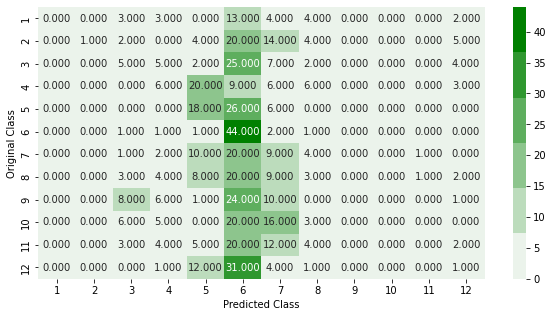

-------------------------------------------------- Precision matrix --------------------------------------------------


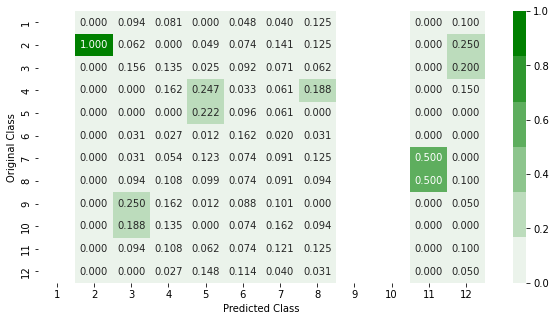

Sum of columns in precision matrix [nan  1.  1.  1.  1.  1.  1.  1. nan nan  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


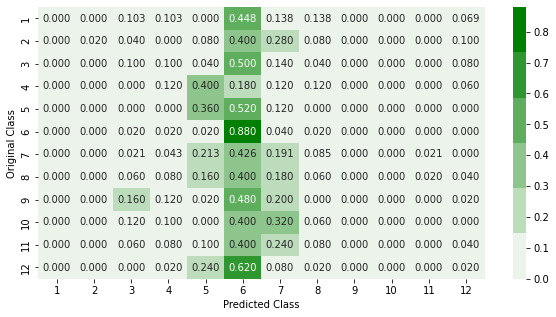

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
plot_confusion_matrix(test_target_labels[:576],y_pred)

Trail - 2

Using Transfer Learning on a Pre-trained model

In [41]:
model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(512,512,3),
    classifier_activation='softmax'
)
for layer in model.layers:
    layer.trainable = False

In [42]:
input_layer=layers.Input(shape=model.output_shape[1:],name='input_layer')
Conv1=layers.Conv2D(filters=64,kernel_size=(1,1),activation='relu',padding='same',kernel_initializer=initializers.he_normal(seed=18),name='Conv1')(input_layer)
Pool1=MaxPool2D(pool_size=(2,2),strides=(2,2),name='Pool1')(Conv1)
flatten=Flatten(name='Flatten')(Pool1)
Dense1=Dense(128,activation='relu',kernel_initializer=initializers.he_normal(seed=98),name='Dense1')(flatten)
Dropout1=Dropout(0.2)(Dense1)
Dense2=Dense(64,activation='relu',name='Dense2')(Dropout1)
Dense3=Dense(32,activation='relu',name='Dense3')(Dense2)
Dense4=Dense(12,activation='softmax',kernel_initializer=initializers.he_normal(seed=54),name='Dense4')(Dense3)
top_model=Model(inputs=input_layer,outputs=Dense4)

In [43]:
final_model=Model(inputs=model.input,outputs=top_model(model.output))


In [44]:
final_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history1 = final_model.fit(train_dataloader,epochs=4)

Epoch 1/4


2021-12-19 06:39:54.536381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 90s 2s/step - loss: 12.6353 - accuracy: 0.1111
Epoch 2/4
36/36 [==============================] - 87s 2s/step - loss: 2.4686 - accuracy: 0.1076
Epoch 3/4
36/36 [==============================] - 89s 2s/step - loss: 2.4548 - accuracy: 0.1311
Epoch 4/4
36/36 [==============================] - 92s 3s/step - loss: 2.4483 - accuracy: 0.1302


In [47]:
history2 = final_model.fit(train_dataloader,epochs=4)

Epoch 1/4
36/36 [==============================] - 89s 2s/step - loss: 2.4310 - accuracy: 0.1571
Epoch 2/4
36/36 [==============================] - 89s 2s/step - loss: 2.4002 - accuracy: 0.1589
Epoch 3/4
36/36 [==============================] - 90s 2s/step - loss: 2.3762 - accuracy: 0.1884
Epoch 4/4
36/36 [==============================] - 91s 2s/step - loss: 2.2974 - accuracy: 0.2266


In [49]:
history2 = final_model.fit(train_dataloader,epochs=4)

Epoch 1/4
36/36 [==============================] - 90s 2s/step - loss: 2.2631 - accuracy: 0.2352
Epoch 2/4
36/36 [==============================] - 87s 2s/step - loss: 2.2201 - accuracy: 0.2309
Epoch 3/4
36/36 [==============================] - 90s 2s/step - loss: 2.2124 - accuracy: 0.2448
Epoch 4/4
36/36 [==============================] - 89s 2s/step - loss: 2.0969 - accuracy: 0.3038


In [51]:
history2 = final_model.fit(train_dataloader,epochs=4)

Epoch 1/4
36/36 [==============================] - 89s 2s/step - loss: 2.1023 - accuracy: 0.2700
Epoch 2/4
36/36 [==============================] - 91s 2s/step - loss: 2.0847 - accuracy: 0.2821
Epoch 3/4
36/36 [==============================] - 89s 2s/step - loss: 2.1457 - accuracy: 0.2656
Epoch 4/4
36/36 [==============================] - 92s 3s/step - loss: 2.0610 - accuracy: 0.2951


Number of misclassified points  69.96527777777779
-------------------------------------------------- Confusion matrix --------------------------------------------------


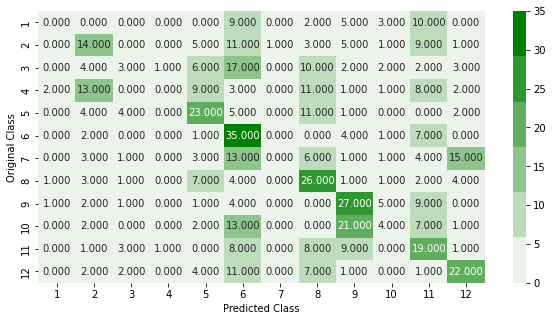

-------------------------------------------------- Precision matrix --------------------------------------------------


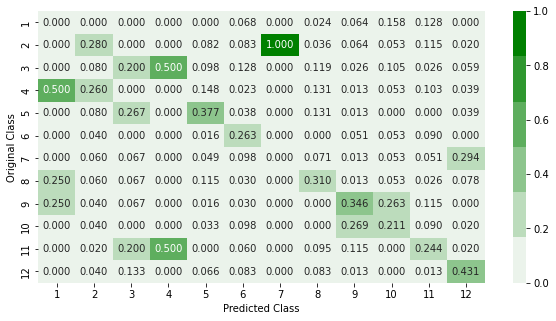

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


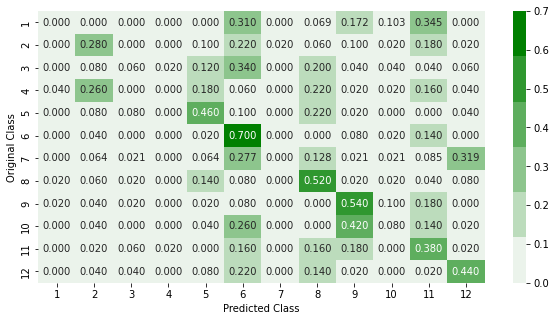

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [52]:
predict_y = final_model.predict(test_dataloader)
y_pred = np.argmax(predict_y,axis = 1)
plot_confusion_matrix(test_target_labels[:576],y_pred)

Analysis:

In [61]:
print('Class id','class name')
for i in range(1,13):
    print(i,le.classes_[i-1])

Class id class name
1 colon
2 endometrium_1
3 endometrium_2
4 kidney
5 liver
6 lung
7 lymph_node
8 pancreas
9 skin_1
10 skin_2
11 small_intestine
12 spleen


1. Overall lung, Pancreas, skin_1, small_intestine, spleen classes are predicted with good percentage. 
2. Overall 7,12 - 3,6 - 4,2
3. Most of the data of lymp_node is predicted as spleen, endometrium_2 is predicted as lung, 13 points of Kidney is predicted as encometrium_1